<a href="https://colab.research.google.com/github/nkorzounUD/DSPS_NKorzoun/blob/main/HW10/aenc_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

author FBB for DSPS2021

# Autoencoder notebook 
create superresolution portraits from low resolution black and white images:
- load a patch of images and lower the resolution
- build an autoencoder with a bottleneck layer much smaller thn the number of pixels in an image
- pass the lower resolution images as imput and the higher resolution images as output
- ask the encoder to predict high resolution images from low resolution ones
- test it on a headshot of yourself

In [1]:
from google.colab import drive

drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [2]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense#, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import optimizers
from keras.callbacks import EarlyStopping

In [3]:
import glob
import h5py
from PIL import Image
import numpy as np
import pylab as pl
%pylab inline
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


In [4]:
cd /content/gdrive/Shareddrives/


/content/gdrive/Shareddrives


In [5]:
ls

DSPS2021/


In [6]:
cd  DSPS2021/

/content/gdrive/Shareddrives/DSPS2021


# 1A  (661) load head shots from known training data - skip to 1B to load images already read in
The first time you will need to dowbload faces95.zip. Uncomment the 2 lines of code below

In [7]:
# this link no longer works due to the backlash of the algorithm that whitened Obama
# but I saved the data in our shared drive
#!wget http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip


In [8]:
#!unzip faces95.zip

In [9]:
!ls data/faces95/*jpg

data/faces95/adhast.10.jpg  data/faces95/llambr.10.jpg
data/faces95/adhast.11.jpg  data/faces95/llambr.11.jpg
data/faces95/adhast.12.jpg  data/faces95/llambr.12.jpg
data/faces95/adhast.13.jpg  data/faces95/llambr.13.jpg
data/faces95/adhast.14.jpg  data/faces95/llambr.14.jpg
data/faces95/adhast.15.jpg  data/faces95/llambr.15.jpg
data/faces95/adhast.16.jpg  data/faces95/llambr.16.jpg
data/faces95/adhast.17.jpg  data/faces95/llambr.17.jpg
data/faces95/adhast.18.jpg  data/faces95/llambr.18.jpg
data/faces95/adhast.19.jpg  data/faces95/llambr.19.jpg
data/faces95/adhast.1.jpg   data/faces95/llambr.1.jpg
data/faces95/adhast.20.jpg  data/faces95/llambr.20.jpg
data/faces95/adhast.2.jpg   data/faces95/llambr.2.jpg
data/faces95/adhast.3.jpg   data/faces95/llambr.3.jpg
data/faces95/adhast.4.jpg   data/faces95/llambr.4.jpg
data/faces95/adhast.5.jpg   data/faces95/llambr.5.jpg
data/faces95/adhast.6.jpg   data/faces95/llambr.6.jpg
data/faces95/adhast.7.jpg   data/faces95/llambr.7.jpg
data/faces95/adha

In [10]:
flist = glob.glob("data/faces95/*jpg")

In [11]:
N = len(flist)
N

1440


## read in data

if you save the data in a npy array you can read it in more quickly. After the first time you run this you can comment out the next 2 cells of code and skip to the np.load command

((70, 70, 1), 540)

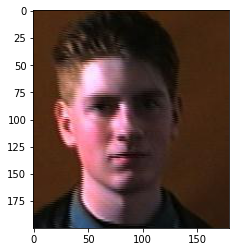

In [12]:
im = Image.open(flist[40])
np_im = numpy.array(im)[:,:,:3].astype(float) / 255 #normalize the images so that they are 0-1
pl.imshow(np_im)
# I am going to need only a subset of the image: the center part where the head is

np_im[25:165:2,25:165:2,:1].shape, np.prod(np_im.shape[1:])

# Figure 1: Sample image from the data set we will be using to train our neural network.

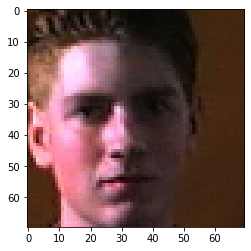

In [13]:
pl.imshow(np_im[25:165:2,25:165:2]);

# Figure 2: Same image as Figure 1 altough now only for a subset of the total image (zoomed in more on the face of the person).

<font color='red'> 461 students - you can skip this and go  straight to loading the images</font>

In [14]:
#skip and read the saved version if you have saved it (after the first time you run this cell)
# I also use a single color channel (black and white)
imgs = np.zeros((N, 70, 70, 1))
for i,f in enumerate(flist):
  if not i%50: print(i)
  im = Image.open(flist[i])
  np_im = numpy.array(im)[:,:,:3].astype(float) / 255 
  # here I collect the certain portion of each image 
  # from pixel 25 to 165 on the x and y axis (25:165)
  # and subsampling by a factor 2 (25:165:2)
  # and I am only choosing 1 color layer: [...,:1]: the R in RGB layers
  imgs[i] = numpy.array(im)[25:165:2,25:165:2,:1].astype(float) / 255 
#uncomment this to save another array of images - I saved the original one as data/faces.npy
#np.save("data/faces_saved.npy", imgs)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400


## 2 lower the resolution#
keep printing the shape of the images as you go along:

make a copy of the original before you lower the res 

- sample the image every other pixel to get a 35x35 image and only (the shape of the image set should be 1440,35,35,1
- create a 75/25 train/test set with the command 
          train_test_split(input, target, test_size = .25, random_state=1) 
          What are the input and output data??
- the data will be fed as a single row of pixels, so for example each imput image should be reshaped so that  the image array so that eachimage is 35*35 long: reshape the 4 arrays: input training, output training, input test and output test so that they are they are the appropriate shape (each should be Nimages x Npixel)


In [15]:
#imgs orig is the full resolution image
imgs_orig = imgs.copy()

In [16]:
# lower the resolution
# example: take one every N pixels
step=2
'''Not sure what stepsize should be'''
imgs_lr = imgs[:,::step,::step]
# slightly better than the line of code above
#imgs_lr = imgs.reshape(...).mean(...).mean(...)
imgs_lr.shape

(1440, 35, 35, 1)

In [17]:
#this is the number of pixels in the image
np.prod(imgs_lr[1].shape), np.prod(imgs[1].shape), 

(1225, 4900)

#### generate a train and test set
If I want to predict the image at the same resolution I will pass the same input as the target variable. Otherwise the target variable will be a full resolution image set and the low input the lower resolution one

In [18]:
X_tr,  X_te, y_tr, y_te = train_test_split(imgs_lr, imgs_orig, test_size = .25, random_state=2)

In [19]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1080, 35, 35, 1), (360, 35, 35, 1), (1080, 70, 70, 1), (360, 70, 70, 1))

In [20]:
#each image needs to be unravel into a flat array
X_tr = X_tr.reshape(len(X_tr), np.prod(X_tr.shape[1:]))
X_te = X_te.reshape(len(X_te), np.prod(X_te.shape[1:]))
y_tr = y_tr.reshape(len(y_tr), np.prod(y_tr.shape[1:]))
y_te = y_te.reshape(len(y_te), np.prod(y_te.shape[1:]))

In [21]:
## important: we feed to the NN rows of pixels, not cubes of pixels
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1080, 1225), (360, 1225), (1080, 4900), (360, 4900))

## 3 build an autoencoder model

Remember that the autoencoder is an hour clock model: the center is a smallest layer

for example your NN layers could be 

324 (input size) -> 256 -> 128 -> 56 -> 128 -> 256 -> 1225 (output size)

In [22]:
img_row=imgs_lr.shape[1]
img_col=imgs_lr.shape[2]
ndim=img_row*img_col
ndim

1225

In [23]:
# this model is 324 (input size) -> 256 -> 128 128 -> 256 -> 1225 (output size)

model = Sequential()
model.add(Dense(256, activation="relu", input_dim=img_row*img_col))
model.add(Dense(128, activation="relu"))
model.add(Dense(56, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(70*70, activation="sigmoid"))


In [24]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               313856    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 56)                7224      
                                                                 
 dense_3 (Dense)             (None, 128)               7296      
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dense_5 (Dense)             (None, 4900)              1259300   
                                                                 
Total params: 1,653,596
Trainable params: 1,653,596
Non-

In [25]:
'''We may want to make our own optimizer for this'''
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)
patience = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#model.compile(optimizer="adadelta", loss="mean_squared_error")

## 4 A train model 

In [26]:
# you can skip this and load the saved model
history = model.fit(X_tr, y_tr, validation_data=(X_te, y_te), epochs=50, batch_size=100, verbose=1, callbacks=[patience])

Epoch 1/50
11/11 [==============================] - 1s 30ms/step - loss: 0.0599 - val_loss: 0.0433
Epoch 2/50
11/11 [==============================] - 0s 11ms/step - loss: 0.0384 - val_loss: 0.0348
Epoch 3/50
11/11 [==============================] - 0s 11ms/step - loss: 0.0327 - val_loss: 0.0314
Epoch 4/50
11/11 [==============================] - 0s 12ms/step - loss: 0.0310 - val_loss: 0.0310
Epoch 5/50
11/11 [==============================] - 0s 11ms/step - loss: 0.0303 - val_loss: 0.0300
Epoch 6/50
11/11 [==============================] - 0s 12ms/step - loss: 0.0293 - val_loss: 0.0289
Epoch 7/50
11/11 [==============================] - 0s 11ms/step - loss: 0.0296 - val_loss: 0.0288
Epoch 8/50
11/11 [==============================] - 0s 11ms/step - loss: 0.0277 - val_loss: 0.0259
Epoch 9/50
11/11 [==============================] - 0s 12ms/step - loss: 0.0267 - val_loss: 0.0273
Epoch 10/50
11/11 [==============================] - 0s 13ms/step - loss: 0.0261 - val_loss: 0.0232
Epoch 11/

In [27]:
out_loss = history.history['loss']
out_val_loss = history.history['val_loss']

In [28]:
len(out_loss), len(out_val_loss)

(33, 33)

In [29]:
epoch_num = np.linspace(1, len(out_loss), len(out_loss), endpoint=True)

In [30]:
out_loss = np.array(out_loss)
out_val_loss = np.array(out_val_loss)

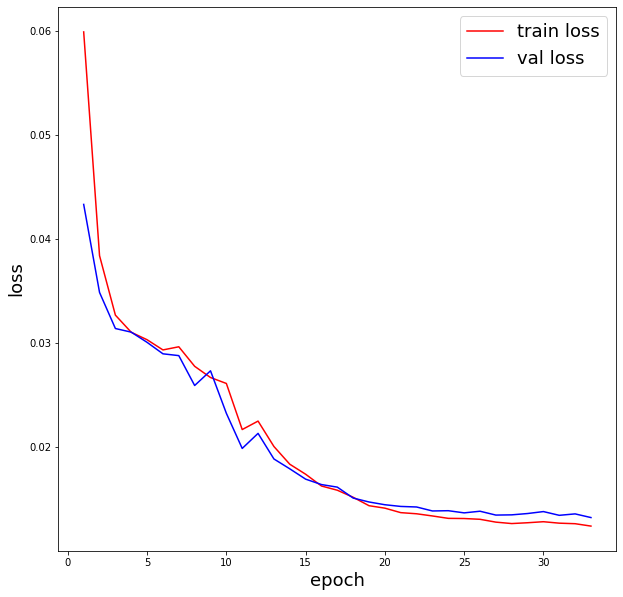

In [31]:
plt.figure(figsize=(10, 10))

plt.plot(epoch_num, out_loss, color='red', linestyle='solid',
         label='train loss')
plt.plot(epoch_num, out_val_loss, color='blue', linestyle='solid',
         label='val loss')

plt.xlabel('epoch', fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.show()


# Figure 3: Plot showing the training and validation loss values for our neural network. We can see here that overfitting does not occur because both loss values seem to plateau at the same rate. Here our plot only goes up to 39 epochs because our network stops after 39 epochs due to our definition of the `callbacks` argument in our model fitting.

## predict

In [32]:
outim = model.predict(X_te)

In [33]:
def compareinout(i, outim, X_tr):
  '''function to plot the input, the prediction and the target in 3 columns
  plots the ith training datum'''
  fig = pl.figure(figsize(10,5))
  ax = fig.add_subplot(131) 
  ax.imshow(X_te[i].reshape(imgs_lr[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(132) 
  ax.imshow(outim[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(133) 
  ax.imshow(y_te[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


1 :	input		      prediction		  target


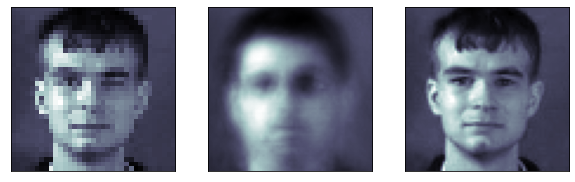

2 :	input		      prediction		  target


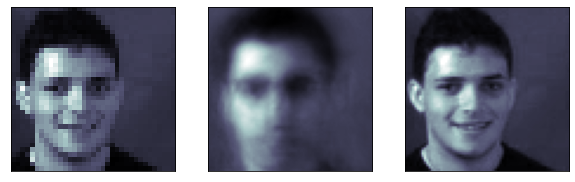

3 :	input		      prediction		  target


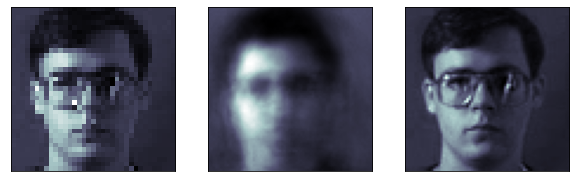

4 :	input		      prediction		  target


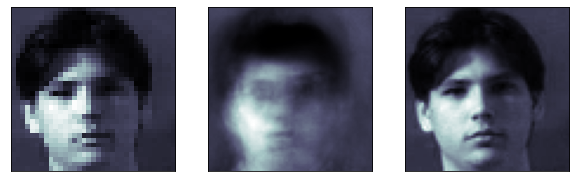

5 :	input		      prediction		  target


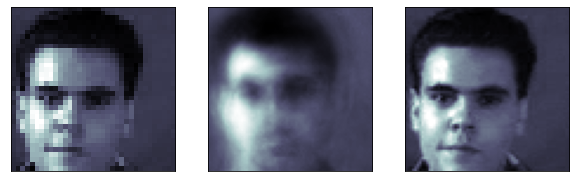

6 :	input		      prediction		  target


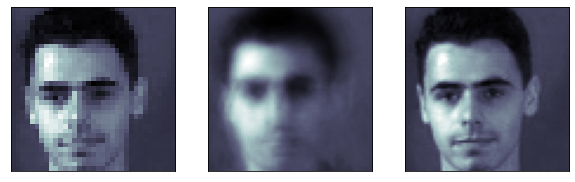

7 :	input		      prediction		  target


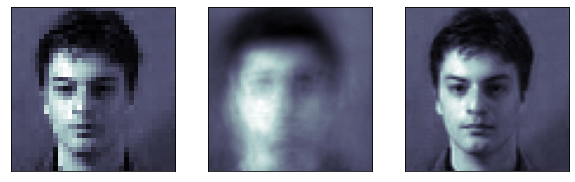

8 :	input		      prediction		  target


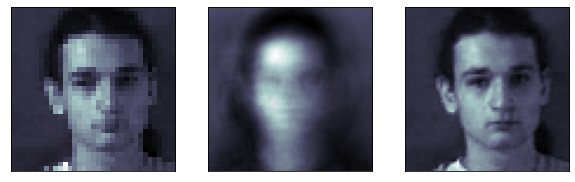

9 :	input		      prediction		  target


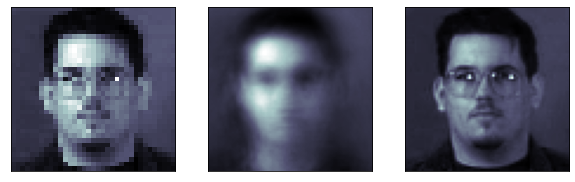

10 :	input		      prediction		  target


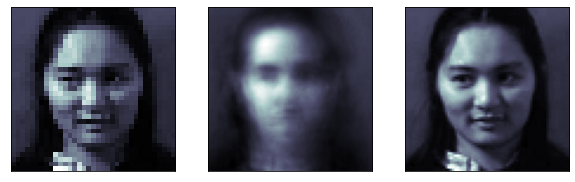

In [34]:
np.random.seed(123)
# pick a few random test images
for i in range(10):
  j = np.random.randint(0, len(X_te))
  print(i + 1, ":\tinput\t\t      prediction\t\t  target")
  compareinout(j, outim, X_te)
  pl.show()

# Figure 4: Figures showing the input, prediction, and target for our neural network. The input image is the far left image and has resolution 35x35. The middle image is a 70x70 resolution prediction of what the input image is and the far right image is the actual target image in a 70x70 resolution.

What do you think? some are pretty good right?! e.g. 1, 4, 6, 7, 8

Some are really bad. 9... why?

# Some predictions look good but others look very bad. This is because we will always lose some information when trying to reconstruct a 70x70 resolution image from a 35x35 resolution image. Hence, our neural network will not predict some images well because of this loss of information.

## OPTIONAl (EC): show the latent representation of the data: the bottleneck layer output

find a visualization that works for you

# test the model on your own image
 depending on the initial size you will have to downsample the image, and extract a single color layer

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
cd /content/drive/My Drive/DSPS

/content/drive/My Drive/DSPS


In [37]:
ls

face.jpeg    HiggsBosonCompetition_AMSMetric_rev1.py  test.zip  training.zip
HiggsBoson/  random_submission.zip                    titanic/


In [38]:
imme = Image.open("/content/drive/My Drive/DSPS/face.jpeg")

(35, 35)


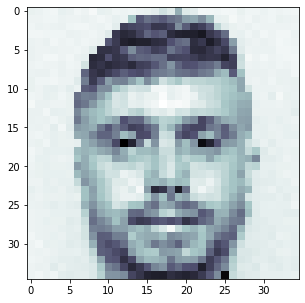

In [51]:
np_imme = numpy.array(imme)[:,:,:3].astype(float) / 255 #normalize the images so that they are 0-1
pl.imshow(np_imme)
#print(np_imme.shape)
target_im=np_imme[140:840:20,130:830:20,:1]
cut_im=np_imme[140:840:20,130:830:20,:1]
#temp=np_imme[::2,::2,:1]
cut_im=cut_im.squeeze()
target_im=target_im.squeeze()
print(cut_im.shape)
pl.imshow(cut_im, cmap="bone")

In [52]:
im_row=cut_im.shape[0]
im_col=cut_im.shape[1]
print("cut image: ", im_row, im_col)
print("target image: ", target_im.shape[0], target_im.shape[1])

cut image:  35 35
target image:  35 35


In [64]:
cut_im.shape

(35, 35)

In [70]:
flat_im = cut_im.reshape(len(cut_im), np.prod(cut_im.shape[1:]))
flat_im.size

1225

In [66]:
flat_im.flatten().shape

(1225,)

In [ ]:
flat_im.flatten()

In [67]:
model.predict(flat_im.flatten())

ValueError: ignored

low resolution version
subsampling by 15

# is it good? if not why not?